In [26]:
import pandas as pd
import numpy as np 
import seaborn as sns

import scipy.stats as stats 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import FunctionTransformer 
from sklearn.compose import ColumnTransformer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [27]:
df = pd.read_csv("data.csv",usecols = ['Age','Fare','Survived'])

In [28]:
df.Age.fillna(df.Age.mean() , inplace =True)

In [29]:
df.isnull().sum()

Survived    0
Age         0
Fare        0
dtype: int64

In [30]:
x = df.iloc[:,1:3]
y = df.iloc[:,0]

In [31]:
x

,Age,Fare
0,22.000000,7.2500
1,38.000000,71.2833
2,26.000000,7.9250
3,35.000000,53.1000
4,35.000000,8.0500
...,...,...
886,27.000000,13.0000
887,19.000000,30.0000
888,29.699118,23.4500
889,26.000000,30.0000


In [32]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [33]:
x_train , x_test ,y_train ,y_test = train_test_split(x,y,test_size= 0.2 ,random_state=42)

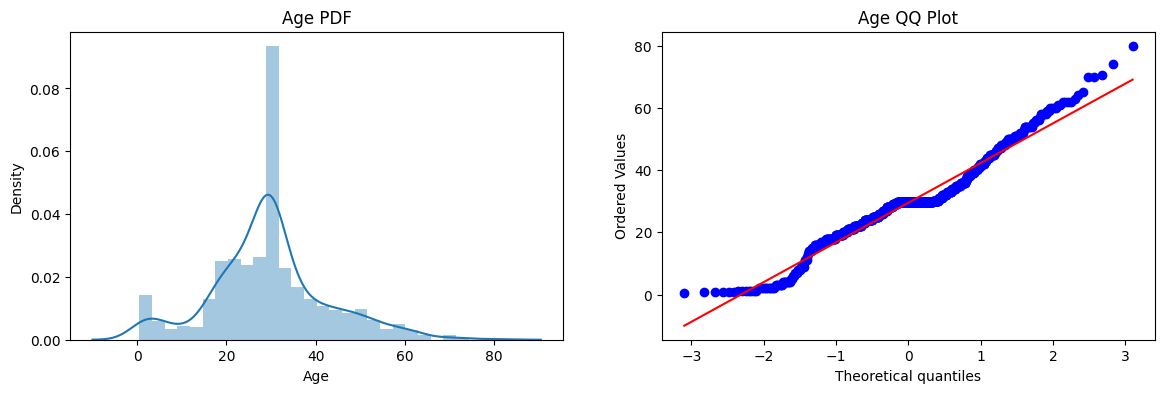

In [34]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(x_train['Age'])
plt.title('Age PDF')

plt.subplot(122)
stats.probplot(x_train['Age'], dist="norm", plot=plt)
plt.title('Age QQ Plot')

plt.show()

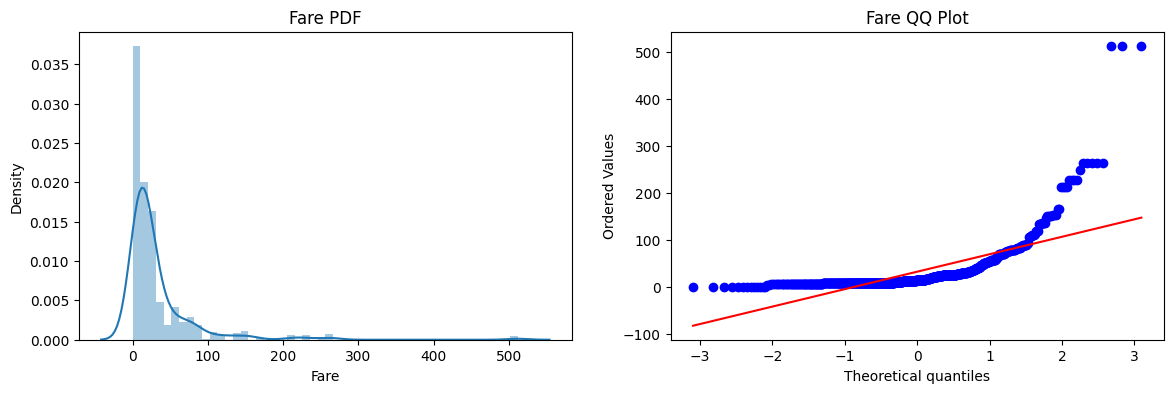

In [35]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(x_train['Fare'])
plt.title('Fare PDF')

plt.subplot(122)
stats.probplot(x_train['Fare'], dist="norm", plot=plt)
plt.title('Fare QQ Plot')

plt.show()

Training model without applying any functional transformation

In [36]:
lr = LogisticRegression()
dtc = DecisionTreeClassifier()

In [37]:
lr.fit(x_train,y_train)
dtc.fit(x_train,y_train)

DecisionTreeClassifier()

In [40]:
lr_pred = lr.predict(x_test)
dtc_pred = dtc.predict(x_test)

In [43]:
accuracy_score(y_test ,lr_pred)


0.6480446927374302

In [44]:
accuracy_score(y_test ,dtc_pred)

0.6871508379888268

Now applying the functional transformer with log transform on both of the columns

In [45]:
trf = FunctionTransformer(func=np.log1p)

In [46]:
x_train_log_transformed = trf.fit_transform(x_train)
x_test_log_transformed = trf.fit_transform(x_test)

In [47]:
lr = LogisticRegression()
dtc = DecisionTreeClassifier()

In [48]:
lr.fit(x_train_log_transformed,y_train)
dtc.fit(x_train_log_transformed,y_train)

DecisionTreeClassifier()

In [52]:
lr_pred = lr.predict(x_test_log_transformed)
dtc_pred = dtc.predict(x_test_log_transformed)

In [53]:
accuracy_score(y_test , lr_pred)

0.6815642458100558

In [54]:
accuracy_score(y_test, dtc_pred)

0.6759776536312849

In [56]:
x_transformed = trf.transform(x)

In [57]:
lr = LogisticRegression()
dtc = DecisionTreeClassifier()

In [58]:
np.mean(cross_val_score(lr, x_transformed , y ,scoring= 'accuracy' , cv= 100))

np.float64(0.68)

In [59]:
np.mean(cross_val_score(dtc, x_transformed , y ,scoring= 'accuracy' , cv= 100))

np.float64(0.6533333333333333)

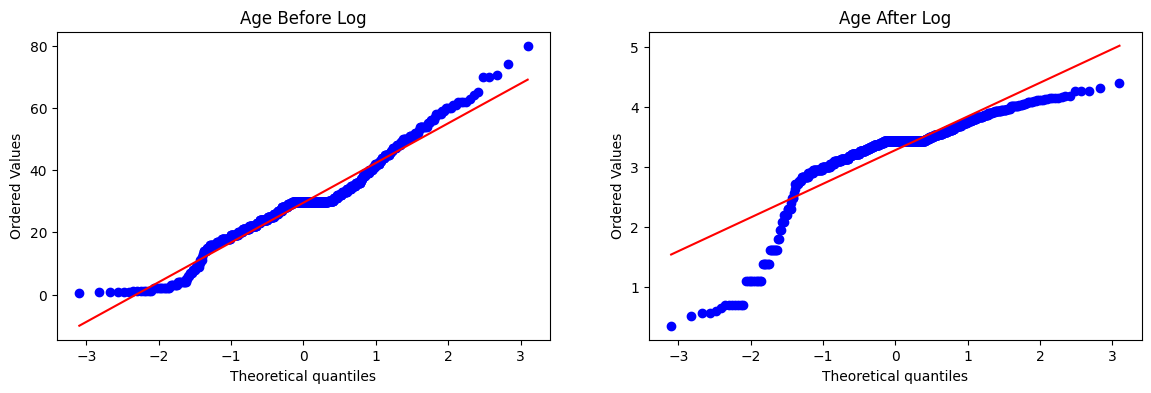

In [61]:
plt.figure(figsize=(14,4))

plt.subplot(121)
stats.probplot(x_train['Age'], dist="norm", plot=plt)
plt.title('Age Before Log')

plt.subplot(122)
stats.probplot(x_train_log_transformed['Age'], dist="norm", plot=plt)
plt.title('Age After Log')

plt.show()

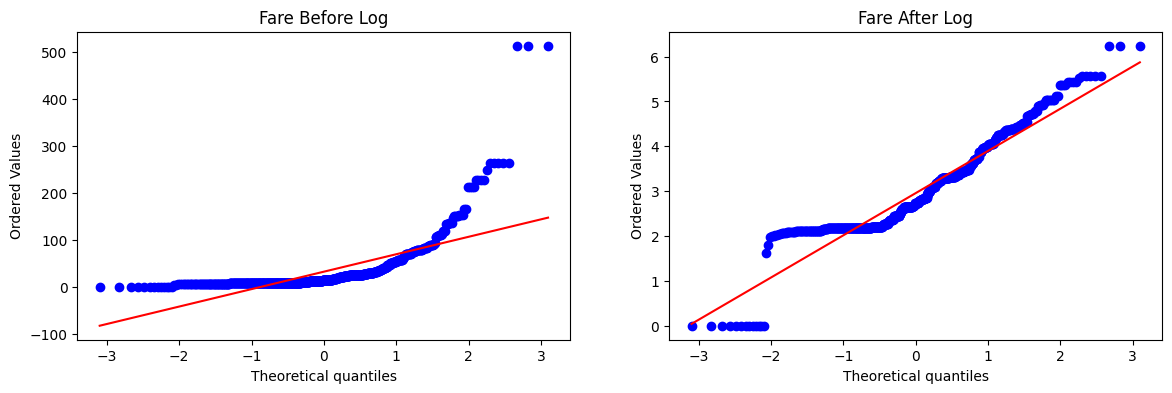

In [60]:
plt.figure(figsize=(14,4))

plt.subplot(121)
stats.probplot(x_train['Fare'], dist="norm", plot=plt)
plt.title('Fare Before Log')

plt.subplot(122)
stats.probplot(x_train_log_transformed['Fare'], dist="norm", plot=plt)
plt.title('Fare After Log')

plt.show()

The above results clearly shows that the Fare column has some improvements after applying log transform 
Whereas , the Age column is more left skewed before. (as the age column was not right skewed initially, so it is not a good idea to apply log transform on any given columns)

Now

Here we are applying column transformer - only for Fare column and Age column is as it is.

In [62]:
t2 = ColumnTransformer([
('log', FunctionTransformer(np.log1p) , ["Fare"])
],remainder='passthrough')

In [64]:
x_train_second_transform_experiment = t2.fit_transform(x_train)
x_test_second_transform_experiment = t2.fit_transform(x_test)

In [65]:
lr = LogisticRegression()
dtc = DecisionTreeClassifier()

In [66]:
lr.fit(x_train_second_transform_experiment,y_train)

LogisticRegression()

In [68]:
dtc.fit(x_train_second_transform_experiment,y_train)

DecisionTreeClassifier()

In [69]:
lr_pred = lr.predict(x_test_second_transform_experiment )
dtc_pred = lr.predict(x_test_second_transform_experiment )

In [72]:
accuracy_score(y_test , lr_pred)


0.6703910614525139

In [73]:
accuracy_score(y_test , dtc_pred)

0.6703910614525139

In [74]:
x_t2 = t2.fit_transform(x)

In [75]:
lr = LogisticRegression()
dtc = DecisionTreeClassifier()

In [77]:
np.mean(cross_val_score(lr, x_t2 , y, scoring='accuracy' , cv = 100))

np.float64(0.6676388888888889)

In [78]:
np.mean(cross_val_score(dtc, x_t2 , y, scoring='accuracy' , cv = 100))

np.float64(0.6411111111111112)

In [79]:
def apply_transform(transform):
    X = df.iloc[:,1:3]
    y = df.iloc[:,0]
    
    trf = ColumnTransformer([('log',FunctionTransformer(transform),['Fare'])],remainder='passthrough')
    
    X_trans = trf.fit_transform(X)
    
    clf = LogisticRegression()
    
    print("Accuracy",np.mean(cross_val_score(clf,X_trans,y,scoring='accuracy',cv=10)))
    
    plt.figure(figsize=(14,4))

    plt.subplot(121)
    stats.probplot(X['Fare'], dist="norm", plot=plt)
    plt.title('Fare Before Transform')

    plt.subplot(122)
    stats.probplot(X_trans[:,0], dist="norm", plot=plt)
    plt.title('Fare After Transform')

    plt.show()

Square Function

Accuracy 0.6431335830212235


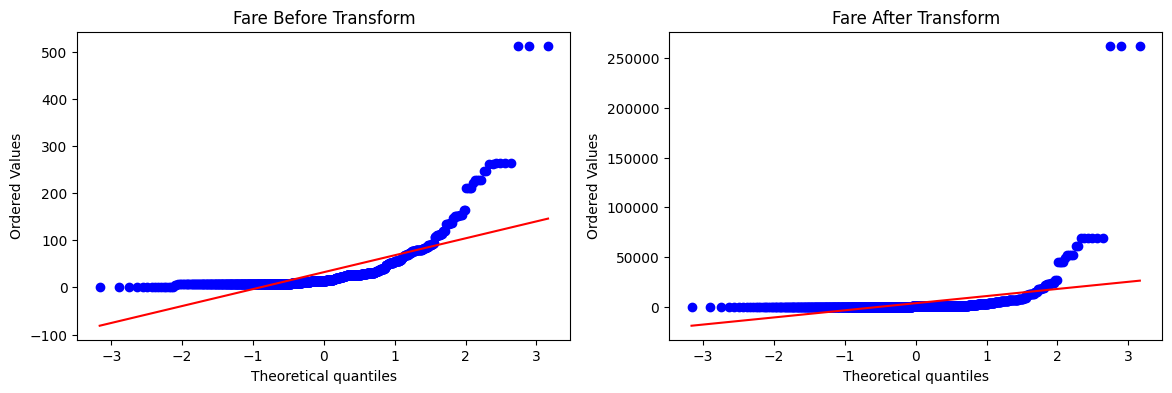

In [81]:
apply_transform(lambda x : x**2)

Cube function

Accuracy 0.6262796504369538


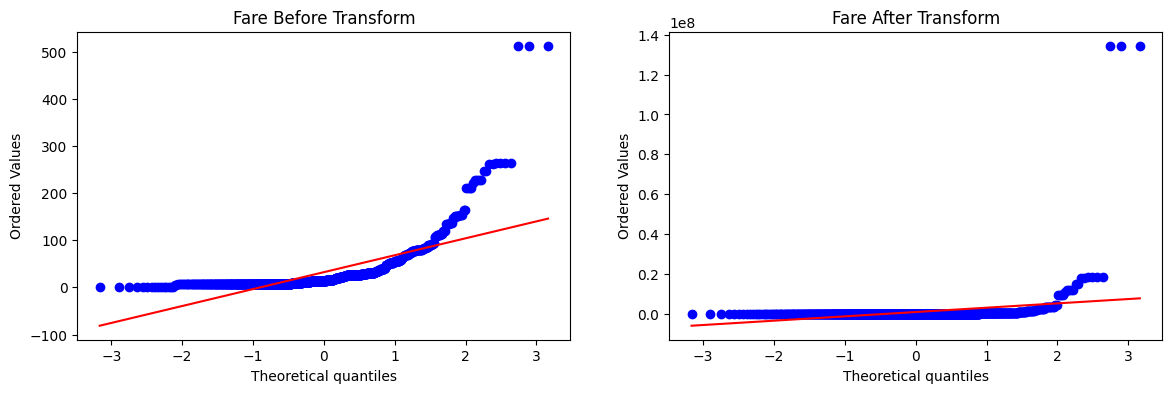

In [82]:
apply_transform(lambda x : x** 3)

Reciprocal Function

Accuracy 0.616167290886392


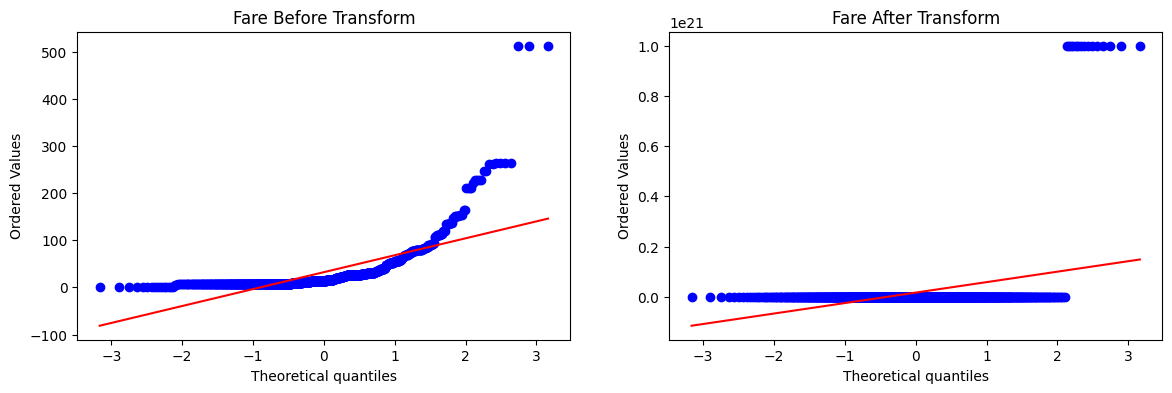

In [84]:
apply_transform(lambda x : 1 / ( x + 0.000000000000000000001))

In nutshell , the log transform worked best (at least on the Fair column) out of all the 

Accuracy 0.6589013732833957


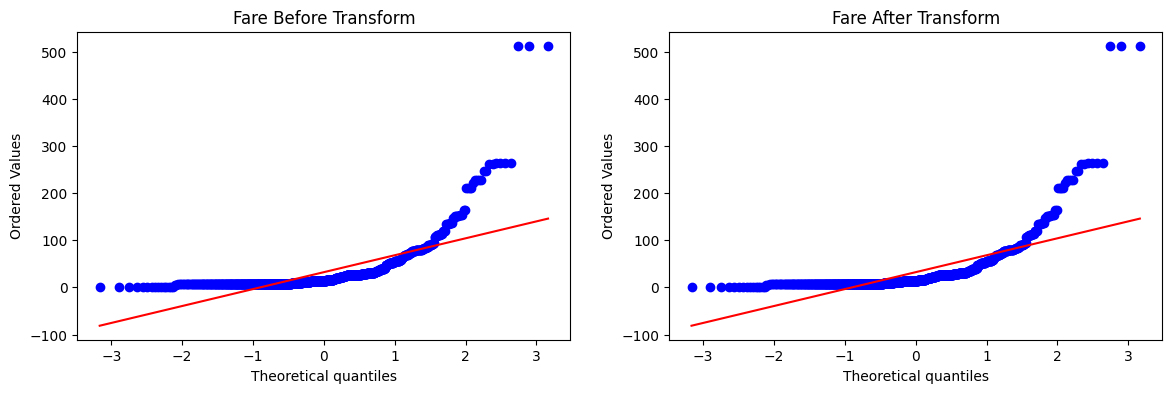

In [86]:
apply_transform(lambda x : x)